# NFI - Intro to OSMNX


OSMNX stands for Open Street Maps and Networkx, and it's a library that helps us convert maps into graphs easily

OSMNX reference: https://osmnx.readthedocs.io/

For reference, please check the author's blog:
https://geoffboeing.com/

In [57]:
#after that we can import it
import osmnx as ox
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

let's pick a point from OSM https://www.openstreetmap.org/

In [3]:
#graph from center point
point = (40.43176, -3.691944)

In [4]:
#we can create a graph from that
G = ox.graph.graph_from_point(point, network_type='walk', dist=800, dist_type='bbox')

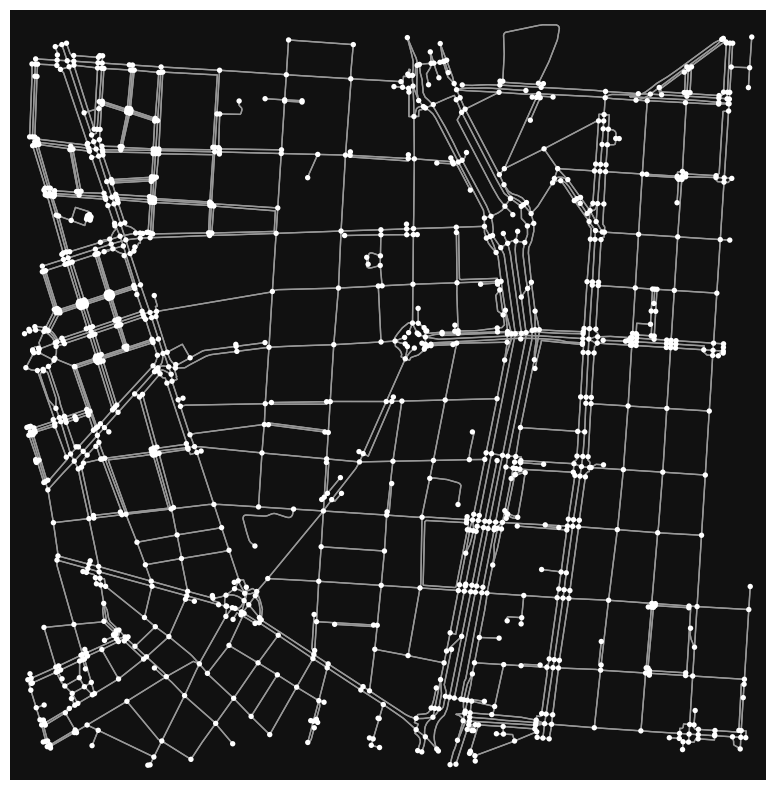

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [5]:
ox.plot.plot_graph(G, figsize=(10, 10), node_size=15)

In [56]:
# Define the place name
G = nx.read_graphml("G_cpt.graphml")

FileNotFoundError: [Errno 2] No such file or directory: 'G_cpt.graphml'

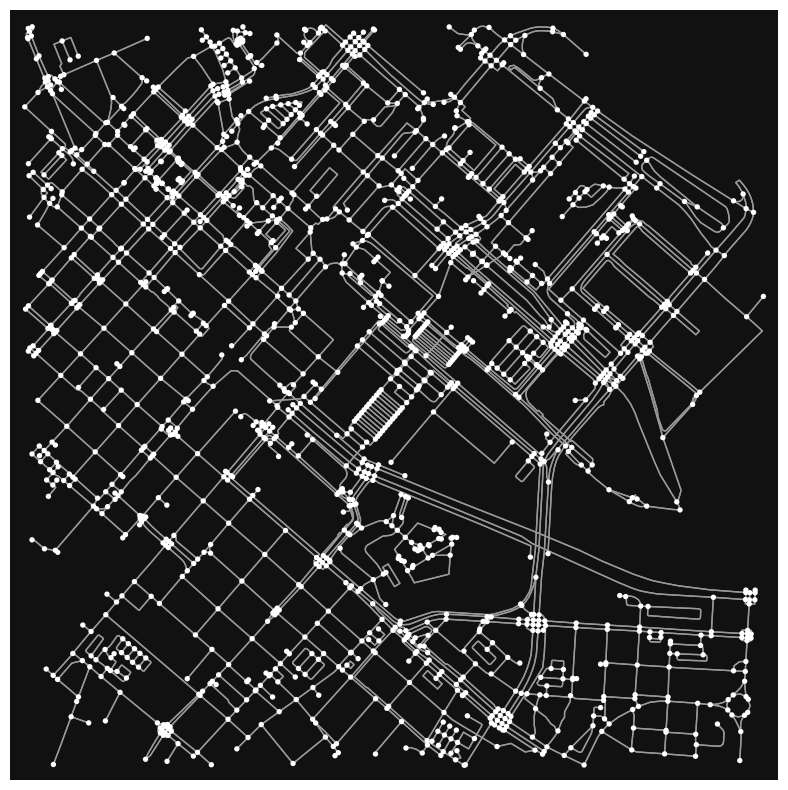

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [55]:
#graph from address
address = "CapeTown, South Africa"
G = ox.graph.graph_from_address(address, network_type='walk', dist=800, dist_type='bbox',simplify=True)
ox.plot.plot_graph(G, figsize=(10, 10), node_size=15)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

https://nominatim.openstreetmap.org/

### cleaning

In [7]:
# get a GeoSeries of consolidated intersections
G_proj = ox.projection.project_graph(G)
ints = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(ints)

283

In [8]:
# compare to number of nodes in original graph
len(G)

1231

In [9]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=True, tolerance=15, dead_ends=False
)
len(G2)

294

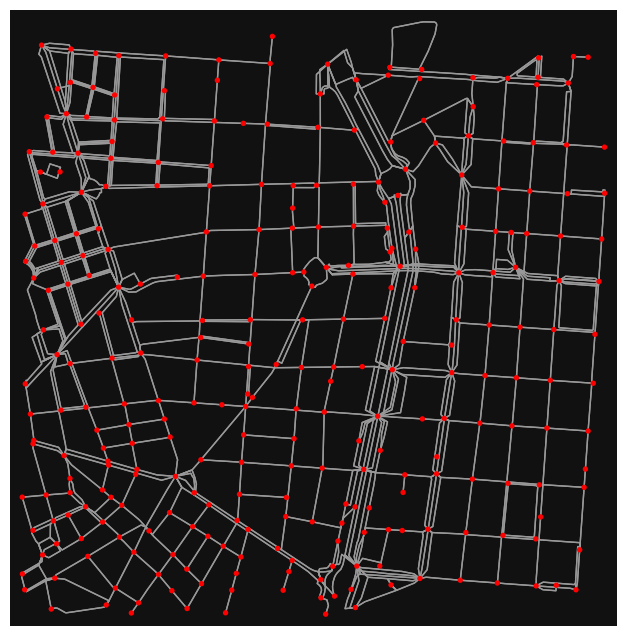

In [10]:
fig, ax = ox.plot.plot_graph(G2, node_color="r")

### converting to dataframe and back

In [11]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,railway,geometry
osmid,,,,,,
21627165,40.426496,-3.687647,4,NaN,NaN,POINT (-3.68765 40.4265)
21990700,40.424938,-3.700755,4,traffic_signals,NaN,POINT (-3.70076 40.42494)
21990702,40.425216,-3.700054,3,NaN,NaN,POINT (-3.70005 40.42522)
21990703,40.425235,-3.700012,4,crossing,NaN,POINT (-3.70001 40.42524)
21990704,40.425365,-3.699723,3,NaN,NaN,POINT (-3.69972 40.42537)


In [12]:
gdf_edges.head()

osmid      highway                 name  oneway  \
u        v           key                                                       
21627165 4225207889  0     4526344  residential  Calle de Hermosilla   False   
         1963430773  0    43405582    secondary     Calle de Serrano   False   
         10920210171 0     4526344  residential  Calle de Hermosilla   False   
         1278839146  0    43405582    secondary     Calle de Serrano   False   
21990700 4260707791  0     4101279  residential  Calle de Fuencarral   False   

                         reversed      length lanes maxspeed  \
u        v           key                                       
21627165 4225207889  0       True   13.518317   NaN      NaN   
         1963430773  0       True   17.814552     4       50   
         10920210171 0      False   11.986967   NaN      NaN   
         1278839146  0      False  102.904534     4       50   
21990700 4260707791  0       True   12.001043     2       50   

                                                                   geometry  \
u        v           key                                                      
21627165 4225207889  0      LINESTRING (-3.68765 40.4265, -3.68781 40.4265)   
         1963430773  0     LINESTRING (-3.68765 40.4265, -3.68761 40.42665)   
         10920210171 0    LINESTRING (-3.68765 40.4265, -3.68756 40.4264...   
         1278839146  0    LINESTRING (-3.68765 40.4265, -3.68774 40.4260...   
21990700 4260707791  0    LINESTRING (-3.70076 40.42494, -3.70079 40.42504)   

                         service access width bridge tunnel  
u        v           key                                     
21627165 4225207889  0       NaN    NaN   NaN    NaN    NaN  
         1963430773  0       NaN    NaN   NaN    NaN    NaN  
         10920210171 0       NaN    NaN   NaN    NaN    NaN  
         1278839146  0       NaN    NaN   NaN    NaN    NaN  
21990700 4260707791  0       NaN    NaN   NaN    NaN    NaN

In [13]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

In [14]:
# what sized area does our network cover in square meters?
G_proj = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
graph_area_m


2478518.5640308885

In [15]:
# show some basic stats about the network
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 1231,
 'm': 3772,
 'k_avg': 6.128350934199838,
 'edge_length_total': 166402.49767571877,
 'edge_length_avg': 44.115190263976345,
 'streets_per_node_avg': 3.168155970755483,
 'streets_per_node_counts': {0: 0, 1: 144, 2: 0, 3: 619, 4: 444, 5: 21, 6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.11697806661251016,
  2: 0.0,
  3: 0.5028432168968319,
  4: 0.3606823720552396,
  5: 0.017059301380991064,
  6: 0.002437043054427295},
 'intersection_count': 1087,
 'street_length_total': 83201.2488378593,
 'street_segment_count': 1886,
 'street_length_avg': 44.115190263976295,
 'circuity_avg': 1.040750199250349,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 283,
 'node_density_km': 496.6676537608773,
 'intersection_density_km': 438.5684318749582,
 'edge_density_km': 67137.88635300493,
 'street_density_km': 33568.943176502435,
 'clean_intersection_density_km': 114.18110967857699}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [16]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.io.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.io.save_graphml(G, filepath="./data/mynetwork.graphml")

In [38]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.betweenness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "betweenness_centrality")

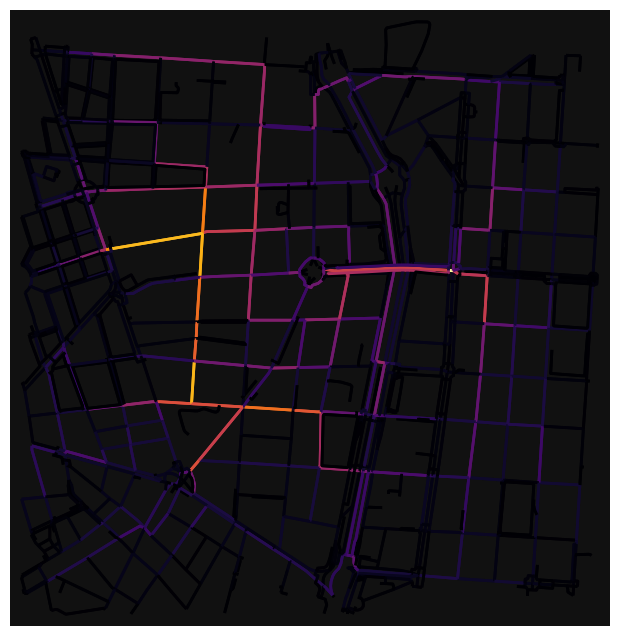

In [40]:
# color edges in original graph with betweene centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "betweenness_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

In [19]:
# convert graph to line graph so edges become nodes and vice versa
#takes a while....
betweenness_centrality = nx.betweenness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "betweenness_centrality")

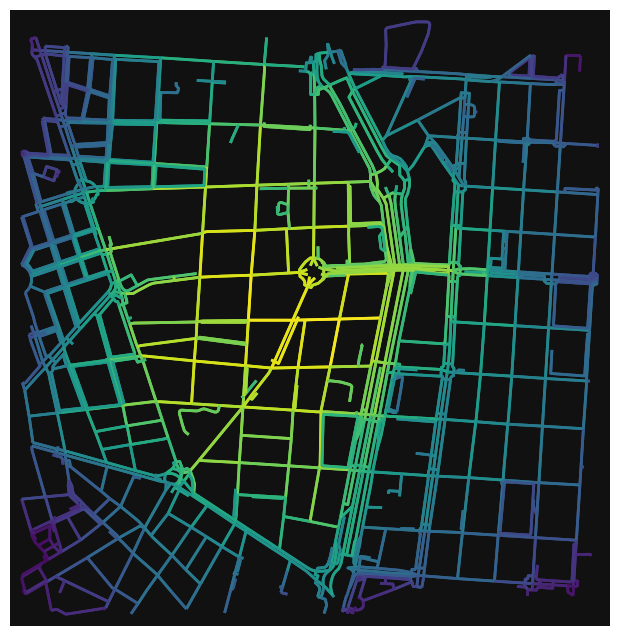

In [20]:
# color edges in original graph with betweeeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "betweenness_centrality", cmap="viridis")
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [21]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [22]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-40.436243, Y=-3.690978) #NFF
dest = ox.distance.nearest_nodes(G, X=40.435306, Y=-3.692332) #NFI

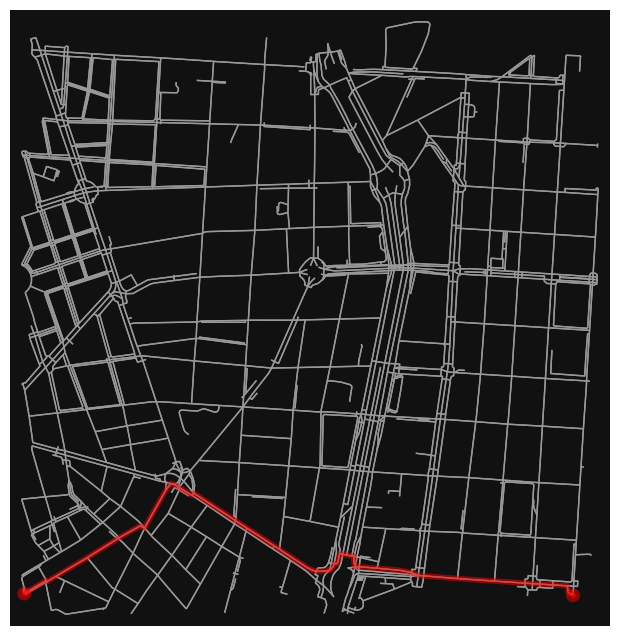

In [23]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.routing.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot.plot_graph_route(G, route, node_size=0)

In [24]:
# how long is our route in meters?
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

1808

In [25]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

1520

Other ways to get networks

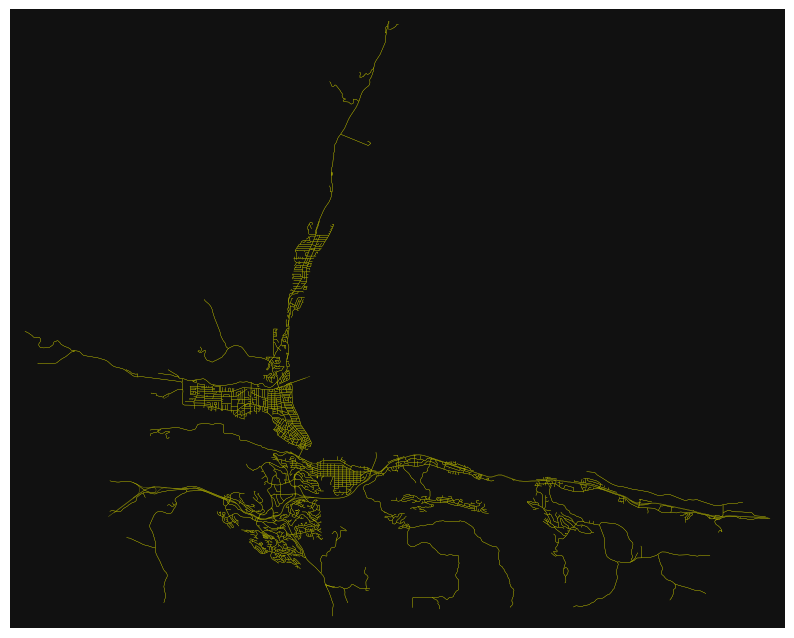

In [59]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "Kamloops", "country": "Canada"}
G = ox.graph.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

In [27]:
# get the boundary for san francisco
gdf = ox.geocode_to_gdf(place)
gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((12.16683 45.49988, 12.16699 45.4998,...",12.166835,45.231247,12.596571,45.577998,71397181,relation,44741,45.437191,12.33459,boundary,administrative,16,0.759398,city,Venice,"Venice, Venezia, Veneto, 30121-30176, Italy"


In [28]:
nodes, edges = ox.graph_to_gdfs(G)

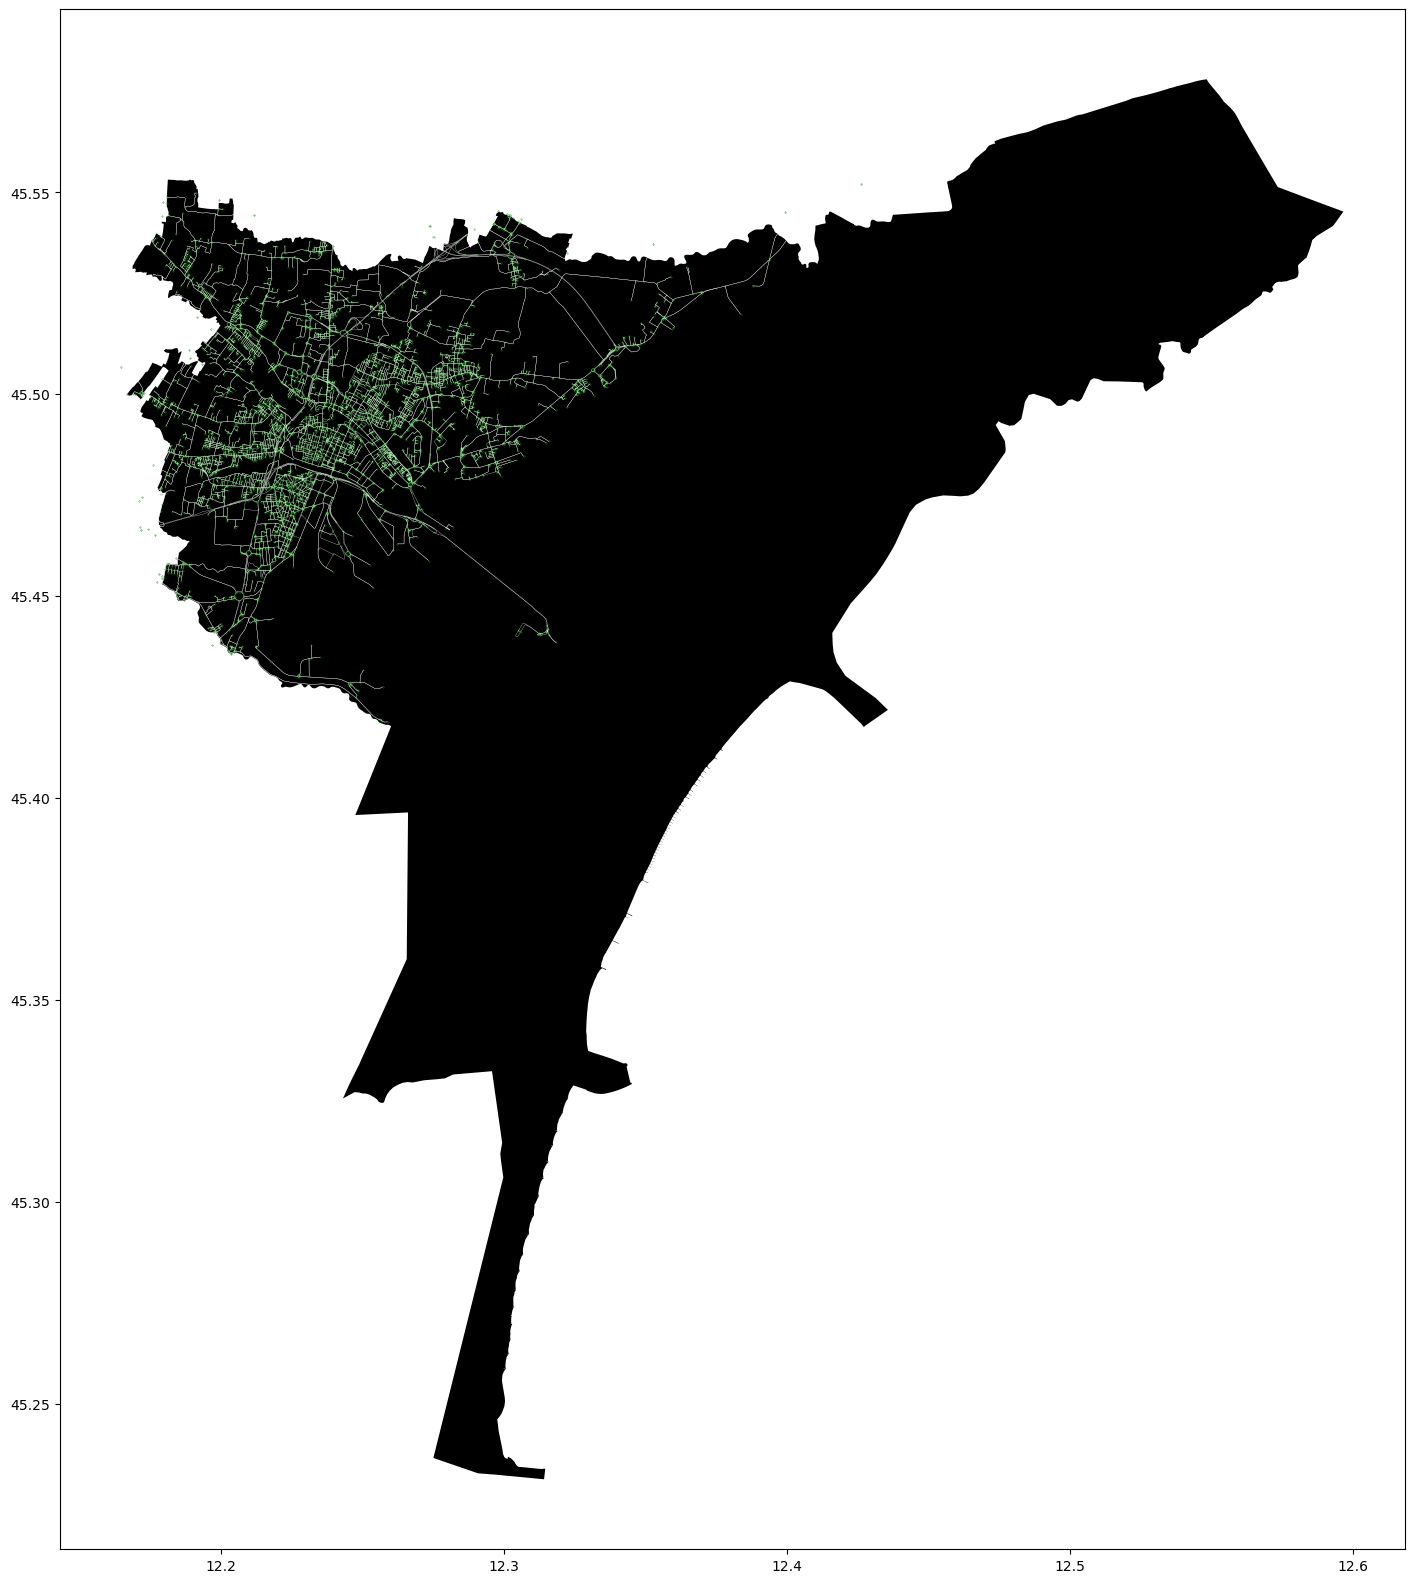

In [29]:
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax, facecolor='black')
edges.plot(ax=ax, linewidth=0.2, edgecolor='white')
nodes.plot(ax=ax, color='green', markersize=.1)
plt.show()

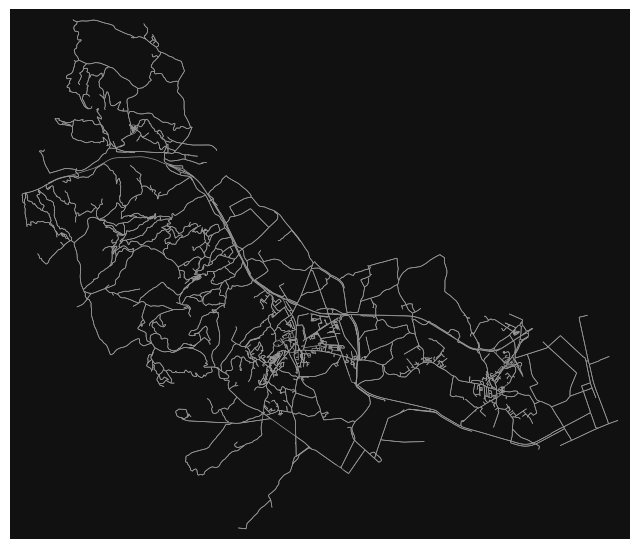

In [30]:
# you can get networks anywhere in the world
G = ox.graph.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot.plot_graph(G, node_size=0, edge_linewidth=0.5)

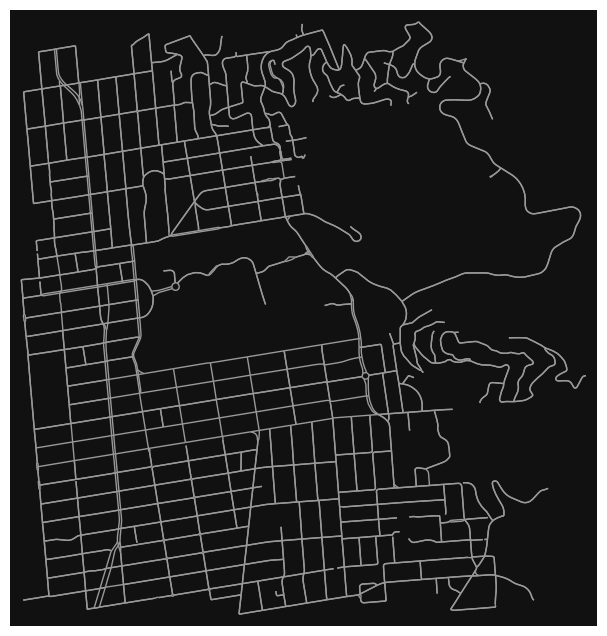

In [31]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot.plot_graph(G, node_size=0)

Get other networked infrastructure types  like rail or electric grids or even the canals of Venice and Amsterdam, using the custom_filter parameter

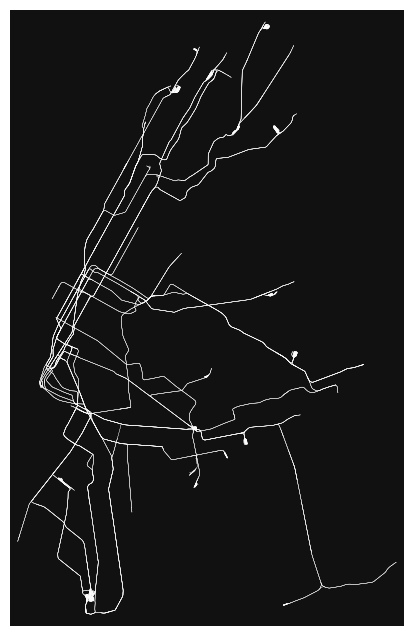

In [32]:
# get NY subway rail network
G = ox.graph.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

### Get any geospatial features' geometries and attributes

se the features module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame

In [33]:
# get all building footprints in some neighborhood
place = "Chinatown, San Francisco, California"
tags = {"building": True}
gdf = ox.features.features_from_place(place, tags)
gdf.shape

(568, 105)

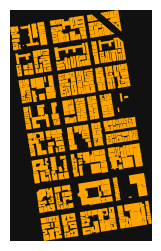

In [34]:
fig, ax = ox.plot.plot_footprints(gdf, figsize=(3, 3))